In [1]:
import torch
import pandas as pd
from pathlib import Path
import numpy as np
import pandas as pd
import random 
from glob import glob
import sklearn

from tqdm.autonotebook import tqdm
from sklearn.metrics import average_precision_score, roc_auc_score
from pathlib import Path

#set up plotting
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize']=[15,5] #for large visuals
%config InlineBackend.figure_format = 'retina'

# opensoundscape transfer learning tools
from opensoundscape.ml.shallow_classifier import MLPClassifier, quick_fit, fit_classifier_on_embeddings
import os
from pathlib import Path
from pydub import AudioSegment

/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_21721/3533495058.py:10: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

Processing data for training set

In [3]:
import os
from pathlib import Path
import pandas as pd

# Define dataset path
dataset_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/")
train_path = dataset_path / "train_5sec"

# Initialize lists for storing file details
audio_files = []
labels = []
start_times = []
end_times = []

# Function to traverse directories and map file information to labels
def traverse_and_map(directory, label):
    if not directory.exists():
        print(f"Directory does not exist: {directory}")
        return
    for root, _, files in os.walk(directory):
        for file in files:
            if file.endswith(".wav"):
                # Prepend full dataset path to the file path
                audio_path = dataset_path / Path(root).relative_to(dataset_path) / file
                audio_files.append(str(audio_path))
                labels.append(label)
                start_times.append(0.0)  # Fixed start time
                end_times.append(5.0)   # Fixed end time

# Iterate over each train size folder
if train_path.exists():
    for train_size_dir in train_path.iterdir():
        if train_size_dir.is_dir():  # Ensure it's a directory
            # Process `pos` and `neg` subdirectories in each train_size directory
            pos_dir = train_size_dir / "pos"
            neg_dir = train_size_dir / "neg"
            traverse_and_map(pos_dir, 1)  # True for "pos" files
            traverse_and_map(neg_dir, 0) # False for "negative" files
else:
    print(f"Train path does not exist: {train_path}")

# Create a DataFrame
data = {
    "file": audio_files,
    "start_time": start_times,
    "end_time": end_times,
    "A": labels  # Store labels under column "A"
}
labels_train = pd.DataFrame(data)

# Set MultiIndex with 'file', 'start_time', and 'end_time'
labels_train.set_index(["file", "start_time", "end_time"], inplace=True)

# Rename the only column to "A"
labels_train.columns = ['A']

# Display the resulting DataFrame
print(labels_train.head())

# Save the DataFrame to a CSV file (optional)
output_path = dataset_path / "audio_metadata_simple.csv"
labels_train.to_csv(output_path)
print(f"DataFrame saved to {output_path}")


                                                                        A
file                                               start_time end_time   
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
DataFrame saved to /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/audio_metadata_simple.csv


In [4]:
print(dataset_path)

/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec


In [5]:
print(labels_train)

                                                                        A
file                                               start_time end_time   
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       1
...                                                                    ..
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        5.0       0

[3900 rows x 1 columns]


Prepare audio Data

In [6]:
labels_train.head(20)

,,,A
file,start_time,end_time,
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_688.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_677.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_663.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_313.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_307.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_267.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_273.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_703.wav,0.0,5.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_717.wav,0.0,5.0,1


Step 1: Train shallow classifier on Perch embeddings

In [7]:
labels_train.index

MultiIndex([('/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_688.wav', ...),
            ('/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_677.wav', ...),
            ('/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_663.wav', ...),
            ('/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_313.wav', ...),
            ('/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_307.wav', ...),
            ('/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_267.wav', ...),
            ('/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/train_5sec/train_size_150/pos/t-11113588_273.wav'

Step 2: Generate embeddings on the training and validation data

In [8]:
model = torch.hub.load('kitzeslab/bioacoustics-model-zoo','rana_sierrae_cnn',trust_repo=True)

Using cache found in /Users/yifeitao/.cache/torch/hub/kitzeslab_bioacoustics-model-zoo_main


In [9]:
emb_train = model.embed(labels_train, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/122 [00:00<?, ?it/s]

/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1725: UserWarning: Audio object is shorter than requested duration: 4.999833333333333 sec instead of 5.0 sec
  warnings.warn(error_msg)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/audio.py:1

In [10]:
csv_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/test_dataset.csv")
audio_file_path = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/test_dataset.wav")
output_folder = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips")
output_csv_dir = Path("/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/")
output_csv = output_csv_dir / "processed_test_dataset_5sec.csv"

# Ensure the output directories exist
output_folder.mkdir(parents=True, exist_ok=True)
output_csv_dir.mkdir(parents=True, exist_ok=True)

# Read the CSV file
df_csv = pd.read_csv(csv_path)

# Determine label based on conditions
df_csv["A"] = df_csv.apply(
    lambda row: 1 if row["label"] == 1 and row["Annotation"] == "BULLFROG" else 0, axis=1
)

# Load the audio file
audio = AudioSegment.from_file(audio_file_path)

# Initialize lists for DataFrame creation
file_paths = []
start_times = []
end_times = []
labels = []

# Partition the audio file into 5-second clips based on CSV
for index, row in df_csv.iterrows():
    start_time = index * 3 * 1000  # in milliseconds
    end_time = start_time + 3 * 1000  # 3 seconds later

    # Extract clip
    clip = audio[start_time:end_time]

    # Save clip to the output folder
    #WT does not have unique row identifier filename column
    filename = row["filename"]
    clip_path = output_folder / filename
    clip.export(clip_path, format="wav")

    # Add details to lists
    file_paths.append(str(clip_path))
    start_times.append(0.0)  
    end_times.append(3.0)  
    labels.append(row["A"])

# Create the DataFrame
df_processed = pd.DataFrame({
    "file": file_paths,
    "start_time": start_times,
    "end_time": end_times,
    "A": labels
})
df_processed.set_index(["file", "start_time", "end_time"], inplace=True)
df_processed.columns = ['A']
# Save the DataFrame to a CSV file
df_processed.to_csv(output_csv, index=False)

print(f"Processed dataset saved to {output_csv}")
print(f"Audio clips saved to {output_folder}")
print(df_processed.head())


/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_21721/2946881073.py:20: ResourceWarning: unclosed file <_io.BufferedReader name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/test_dataset.wav'>
  audio = AudioSegment.from_file(audio_file_path)
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_21721/2946881073.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips/t-11113588_749.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_21721/2946881073.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips/t-11113588_216.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_21721/2946881073.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/User

Processed dataset saved to /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/processed_test_dataset_5sec.csv
Audio clips saved to /Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips
                                                                        A
file                                               start_time end_time   
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        3.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        3.0       1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        3.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        3.0       0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train... 0.0        3.0       0


/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_21721/2946881073.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips/t-11113588_83.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_21721/2946881073.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips/t-11113588_496.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_21721/2946881073.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips/t-11113588_422.wav'>
  clip.export(clip_path, format="wav")
/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_21721/2946881073.py:40: ResourceWarning: unclosed file <_io.BufferedRandom name='/Users/yi

In [11]:
df_processed.head(20)

,,,A
file,start_time,end_time,
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips/t-11113588_749.wav,0.0,3.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips/t-11113588_216.wav,0.0,3.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips/t-11113588_475.wav,0.0,3.0,0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips/t-11113588_780.wav,0.0,3.0,0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips/t-11113588_558.wav,0.0,3.0,0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips/t-11113588_364.wav,0.0,3.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips/t-11113588_675.wav,0.0,3.0,1
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips/t-11113588_80.wav,0.0,3.0,0
/Users/yifeitao/Desktop/SoundHub/SoundHub/train_with_perch/bullfrog_5sec/test/clips/t-11113588_338.wav,0.0,3.0,1


In [12]:
labels_val = df_processed

In [13]:
emb_val = model.embed(labels_val, return_dfs=False, batch_size=32, num_workers=0)

  0%|          | 0/5 [00:00<?, ?it/s]

Step 3: train the classification head on the desired classes

In [14]:
emb_train = torch.tensor(emb_train, dtype=torch.float32)
emb_val = torch.tensor(emb_val, dtype=torch.float32)

# Check the shape of the embeddings
print(f"Original shape of emb_train: {emb_train.shape}")

# Reshape embeddings to [batch_size, channels, height, width]
height, width = 32, 16  # Ensure height * width = 512
emb_train = emb_train.view(emb_train.shape[0], 1, height, width)
emb_val = emb_val.view(emb_val.shape[0], 1, height, width)

# Verify the reshaped embeddings
print(f"Reshaped emb_train: {emb_train.shape}")
print(f"Reshaped emb_val: {emb_val.shape}")

Original shape of emb_train: torch.Size([3900, 512])
Reshaped emb_train: torch.Size([3900, 1, 32, 16])
Reshaped emb_val: torch.Size([150, 1, 32, 16])


In [15]:
import torch.nn as nn

if isinstance(model.network, nn.Sequential):
    first_layer = model.network[0]
    if isinstance(first_layer, nn.Conv2d):
        model.network[0] = nn.Conv2d(
            in_channels=1,
            out_channels=first_layer.out_channels,
            kernel_size=first_layer.kernel_size,
            stride=first_layer.stride,
            padding=first_layer.padding
        )

In [19]:
emb_train.shape

torch.Size([3900, 3, 32, 16])

In [20]:
emb_val.shape

torch.Size([150, 3, 32, 16])

In [18]:
emb_train = emb_train.repeat(1, 3, 1, 1)  # Duplicate to 3 channels
emb_val = emb_val.repeat(1, 3, 1, 1)

In [21]:
import torch.nn as nn

model.network.fc = nn.Linear(in_features=model.network.fc.in_features, out_features=1)


In [22]:
quick_fit(model.network, emb_train, labels_train.values, emb_val, labels_val.values, steps=1000)


/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:110: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_features = torch.tensor(train_features, dtype=torch.float32, device=device)
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/opensoundscape/ml/shallow_classifier.py:115: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  validation_features = torch.tensor(


KeyboardInterrupt: 

Step 4: evaluate

In [23]:
emb_val

tensor([[[[3.8753e+00, 0.0000e+00, 1.8998e-01,  ..., 1.2865e+00,
           7.7636e-01, 8.4410e-02],
          [0.0000e+00, 4.2781e-01, 2.3483e+00,  ..., 2.1449e-01,
           8.1699e-03, 4.2079e-01],
          [8.7931e-01, 8.9579e-01, 0.0000e+00,  ..., 1.1833e+00,
           4.9968e+00, 0.0000e+00],
          ...,
          [3.2899e-01, 1.2384e+00, 2.4923e-02,  ..., 3.4280e+00,
           4.9741e-03, 0.0000e+00],
          [4.5008e-01, 1.3956e+00, 2.0218e-02,  ..., 5.4434e-01,
           0.0000e+00, 0.0000e+00],
          [3.9962e-01, 4.1867e-02, 5.6129e-02,  ..., 9.9965e-01,
           2.0127e+00, 4.5198e-04]],

         [[3.8753e+00, 0.0000e+00, 1.8998e-01,  ..., 1.2865e+00,
           7.7636e-01, 8.4410e-02],
          [0.0000e+00, 4.2781e-01, 2.3483e+00,  ..., 2.1449e-01,
           8.1699e-03, 4.2079e-01],
          [8.7931e-01, 8.9579e-01, 0.0000e+00,  ..., 1.1833e+00,
           4.9968e+00, 0.0000e+00],
          ...,
          [3.2899e-01, 1.2384e+00, 2.4923e-02,  ..., 3.4280

In [32]:
# Create a mask for NaN values
nan_mask = torch.isnan(emb_val)

# Replace NaN values with 0
emb_val[nan_mask] = 0.0


/var/folders/v4/chwhws6x79ncg51bwr5778b00000gn/T/ipykernel_21721/3567016229.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  preds = model.network(torch.tensor(emb_val).float()).detach().numpy()
/opt/anaconda3/envs/opensoundscape_env/lib/python3.9/site-packages/matplotlib_inline/config.py:68: DeprecationWarning: InlineBackend._figure_format_changed is deprecated in traitlets 4.1: use @observe and @unobserve instead.
  def _figure_format_changed(self, name, old, new):


0.6730666666666667

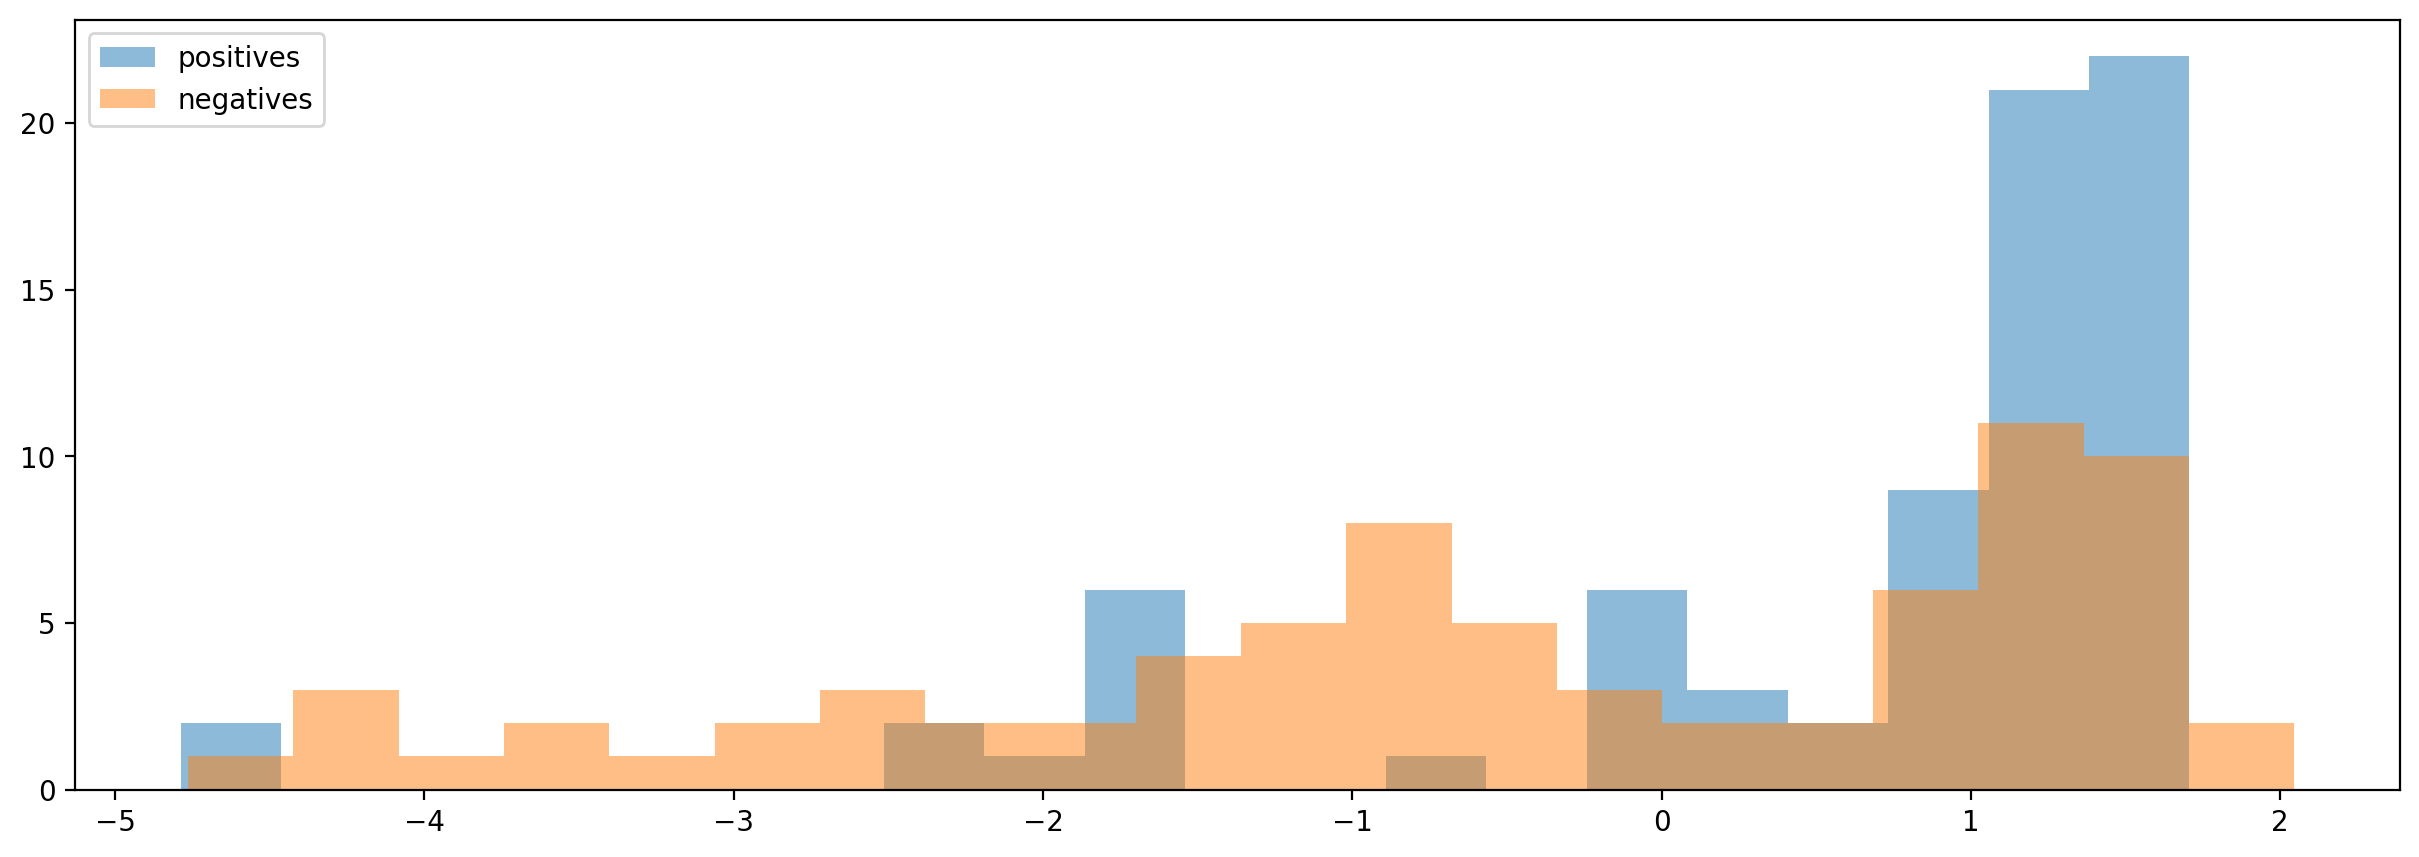

In [24]:
# make predictions by passing the embeddings through the classifier
preds = model.network(torch.tensor(emb_val).float()).detach().numpy()

# plot histogram of scores for positive and negative clips
plt.hist(preds[labels_val==True],bins=20,alpha=0.5,label='positives')
plt.hist(preds[labels_val==False],bins=20,alpha=0.5,label='negatives')
plt.legend()

# calculate the area under the ROC score
roc_auc_score(labels_val.values,preds,average=None)